In [1]:
import numpy as np
from tifffile import imread
from glob import glob
import re
import nrrd
import tifffile
import os
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
directory = "/data2/Data/f10542/"
# fname = "f10542_postfix_gad-405_vglut-647.ome.btf"
# file_path = "/home/tyler/Dropbox/data/20181127/f10542/f10542_postfix_gcamp.ome.btf"
# file_path = "/home/tyler/Dropbox/data/20181127/f10542/f10542_alive_isosbestic_gcamp_0004.ome.btf"
# file_path = directory + fname

get_num = re.compile(".*_zplane=(\d*).*\.mmap")
get_z = lambda x: int(get_num.search(x).group(1))
planes = glob(directory + "f10542_zplane=*_els_*.mmap")
planes = sorted(planes, key=lambda a: get_z(a))
nZ = len(planes)
print(f"Number of planes: {nZ}")

Number of planes: 29


In [3]:
def prepare_shape(mytuple):
    """ This promotes the elements inside a shape into np.uint64. It is intended to prevent overflows
        with some numpy operations that are sensitive to it, e.g. np.memmap """
    if not isinstance(mytuple, tuple):
        raise Exception("Internal error: prepare_shape() passed a non-tuple")
    return tuple(map(lambda x: np.uint64(x), mytuple))

# from Caiman
def load_memmap(filename, mode='r'):
    """ Load a memory mapped file created by the function save_memmap
    Args:
        filename: str
            path of the file to be loaded
        mode: str
            One of 'r', 'r+', 'w+'. How to interact with files
    Returns:
        Yr:
            memory mapped variable
        dims: tuple
            frame dimensions
        T: int
            number of frames
    Raises:
        Exception "Unknown file extension"
    """
    if ('.mmap' in filename):
        # Strip path components and use CAIMAN_DATA/example_movies
        # TODO: Eventually get the code to save these in a different dir
        file_to_load = filename
        filename = os.path.split(filename)[-1]
        fpart = filename.split('_')[1:-1] # The filename encodes the structure of the map
        d1, d2, d3, T, order = int(fpart[-9]), int(fpart[-7]
                                                   ), int(fpart[-5]), int(fpart[-1]), fpart[-3]
        Yr = np.memmap(file_to_load, mode=mode, shape=prepare_shape((
            d1 * d2 * d3, T)), dtype=np.float32, order=order)
        return (Yr, (d1, d2), T) if d3 == 1 else (Yr, (d1, d2, d3), T)
    else:
        logging.error("Unknown extension for file " + str(filename))
        raise Exception('Unknown file extension (should be .mmap)')

In [6]:
small_images = None
for z,pfile in enumerate(planes):
    pfile = planes[z]
    Yr, dims, T = load_memmap(pfile)
    plane = np.reshape(Yr.T, [T] + list(dims), order='F')
    small_plane = resize_volume(plane, 0.5, 0.5)
    if small_images is None:
        # T x H x W
        shape = small_plane.shape
        small_images = np.zeros([shape[0],nZ,*shape[1:]])

    small_images[:,z] = small_plane

In [10]:
small_images.shape

(5437, 29, 176, 256)

In [18]:
np.save(directory+"small_motion_corrected_images.npy", small_images)

In [19]:
print(directory+"small_motion_corrected_images.npy")

/data2/Data/f10542/small_motion_corrected_images.npy


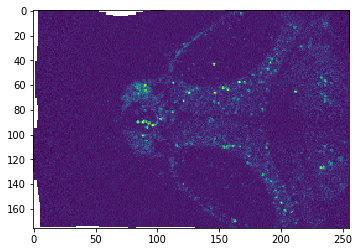

In [15]:
plt.imshow(small_images[110,0])

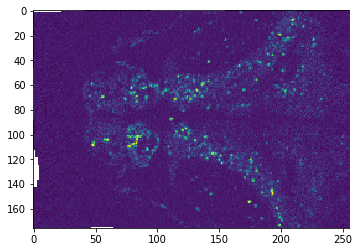

In [16]:
plt.imshow(small_images[110,5])

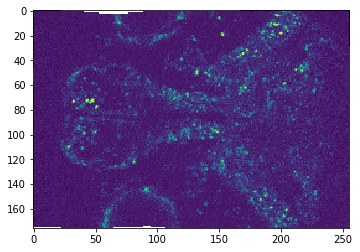

In [17]:
plt.imshow(small_images[110,10])

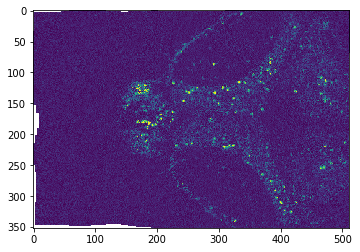

In [35]:
plt.imshow(images[109])

In [ ]:
# directory, fname = os.path.split(file_path)
name, ext = os.path.splitext(file_path)
name, ext2 = os.path.splitext(name)
ext = ext + ext2
tiff = tifffile.imread(file_path,)

# Z x T? x C? x X x Y
# where ? is optional and T is retakes ("time") and C is channel eg gad or vglut
tiff.shape

In [ ]:
alive, header = nrrd.read(directory+"f10542_alive_isosbestic_gcamp_0004.nrrd")